In [4]:
import random
import matplotlib.pyplot as plt
import scipy.special as sps  
import numpy as np
import pandas as pd
from symfit import Parameter, Variable, parameters, variables, sin, cos, Fit
import statistics


In [5]:

def gettingstartpoints(numberofcells = 50,weightscellcycledistributions=[100,0,0],
                       lambdaG1 = 1.15,kappaG1 = 9,lambdaS = 16.9,kappaS = 128,lambdaG2 = 5.59,kappaG2 = 19,lambdaM=0,kappaM=0,
                      outputpath='',treatment='DMSO'):
    import random
    import matplotlib.pyplot as plt
    import scipy.special as sps  
    import numpy as np

    data=[]
    phases=[]
    alllengths=[]
    lengthallG1=[]
    lengthallS=[]
    lengthallG2=[]
    lengthallM=[]

    for cell in list(range(1,int(numberofcells)+1)):
        starttime=0
        startphase = random.choices(["G1",'S','G2M'],weights=weightscellcycledistributions)
        #print(startphase[0])
        lengthG1=np.random.gamma(shape=kappaG1,scale=1/lambdaG1)
        lengthS=np.random.gamma(shape=kappaS,scale=1/lambdaS)
        lengthG2=np.random.gamma(shape=kappaG2,scale=1/lambdaG2)
        lengthM=np.random.gamma(shape=kappaM,scale=1/lambdaM)
        maximallength=lengthG1+lengthS+lengthG2+lengthM
        #print("lengthG1",lengthG1)
        #print("lengthS",lengthS)
        #print("lengthG2",lengthG2)

        if startphase[0] == 'G1':
            starttime=np.random.uniform(0,lengthG1,1)
            #starttime=0
            #print(starttime[0])
        if startphase[0] == 'S':
            starttime=np.random.uniform(lengthG1,lengthG1+lengthS,1)
            #print(starttime[0])

        if startphase[0] == 'G2M':
            starttime=np.random.uniform(lengthG1+lengthS,lengthG1+lengthS+lengthG2+lengthM,1)
            #print(starttime[0])

        data +=[starttime]
        phases +=[startphase[0]]
        lengthallG1+=[lengthG1]
        lengthallS+=[lengthS]
        lengthallG2+=[lengthG2]
        lengthallM+=[lengthM]
        alllengths +=[maximallength]
        
    if treatment == 'DMSO' or treatment == 'control' or treatment == 'MQ':
        colouring = '#5B9BD5' 
    elif treatment == 'V1' or treatment == 'dTAG-V1':
        colouring = '#FF5050'
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,sharey=True)
    fig.suptitle(str('Modelled gamma first cycle '+treatment))
    fig.set_figwidth(10)
    ax1.hist(lengthallG1,bins=50,color=[colouring])
    ax1.set_title('G1 phase')
    ax1.text(0.45,0.98, s=str('lambda: '+str(lambdaG1)+'\nkappa: '+str(kappaG1)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax1.transAxes)
    ax1.set_xlim(0,24)
    ax2.hist(lengthallS,bins=50,color=[colouring])
    ax2.set_title('S phase')
    ax2.set_xlim(0,24)
    ax2.text(0.45,0.98, s=str('lambda: '+str(lambdaS)+'\nkappa: '+str(kappaS)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax2.transAxes)
    ax3.hist(lengthallG2,bins=50,color=[colouring])
    ax3.set_title('G2 phase')
    ax3.text(0.45,0.98, s=str('lambda: '+str(lambdaG2)+'\nkappa: '+str(kappaG2)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax3.transAxes)
    ax3.set_xlim(0,24)
    ax4.hist(lengthallM,bins=50,color=[colouring])
    ax4.set_title('M phase')
    ax4.text(0.45,0.98, s=str('lambda: '+str(lambdaM)+'\nkappa: '+str(kappaM)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax4.transAxes)
    ax4.set_xlim(0,1.5)
    fig.savefig(str(outputpath+'modelledgammadistributions_1'+treatment+'_lastmodel.png'))
    plt.close()
    
    #for i in range(0,len(alllengths)):
    #    summation=lengthallG1[i]+lengthallS[i]+lengthallG2[i]+lengthallM[i]
    #    print(alllengths[i],summation)
    return [data,phases,alllengths,lengthallG1,lengthallS,lengthallG2,lengthallM]




In [6]:
##For one cell the second cell cycle can vary

###### --> Perminant stallment of population in G1!
### --> Also stalling in G2 possible.

def NocodazoleTrapG2(data,phases,alllengthsinput,lengthallG1input,lengthallSinput,lengthallG2input,lengthallMinput,
                          lambdaG1_2nd = 8,kappaG1_2nd = 40,lambdaS_2nd = 16.9,kappaS_2nd = 128,lambdaG2_2nd = 5.59,kappaG2_2nd = 19,lambdaM_2nd=0,kappaM_2nd=0,
                          lambdaG1_3rd = 2.6,kappaG1_3rd = 30,lambdaS_3rd = 16.9,kappaS_3rd = 128,lambdaG2_3rd = 5.59,kappaG2_3rd = 19,lambdaM_3rd=0,kappaM_3rd=0,
                          progressionpercentage=100,progressionpercentage_2nd=100,
                          stallingcells_1st_G1=0,stallingcells_2nd_G1=0,stallingcells_3rd_G1=0,
                          stallingcells_1st_G2=0,stallingcells_2nd_G2=0,stallingcells_3rd_G2=0,
                          takingtimepoints=17,deltatime=3,
                          outputpath='',treatment='DMSO',
                         nocodazole_after=72,efficiencynocodazole=0):
    
    timecoursestart=[data]
    phasecycles = []
    phasecyclesRy=[]
    phasecyclesRx=[]
    countingdictionary={}
    realtimehours=0
    
    nocodazole_after=nocodazole_after
    
    alllengths=alllengthsinput[:]
    alllengthsinput=alllengthsinput[:]
    lengthallG1=lengthallG1input[:]
    lengthallG1input=lengthallG1input[:]
    lengthallS=lengthallSinput[:]
    lengthallSinput=lengthallSinput[:]
    lengthallG2=lengthallG2input[:]
    lengthallG2input=lengthallG2input[:]
    lengthallM=lengthallMinput[:]
    lengthallMinput=lengthallMinput[:]
    
    
    modelledG1_2nd=[]
    modelledS_2nd=[]
    modelledG2_2nd=[]
    modelledM_2nd=[]
    modelledmaxlength_2nd=[]
    modelledG1_3rd=[]
    modelledS_3rd=[]
    modelledG2_3rd=[]
    modelledM_3rd=[]
    modelledmaxlength_3rd=[]

    G1startphasenumbers=0
    Sstartphasenumbers=0
    G2Mstartphasenumbers=0
    G2startphasenumbers=0
    Mstartphasenumbers=0
    #cyclingorquiescent=[]
    #for timepoint in range(0,takingtimepoints):
    #    cyclingorquiescent[timepoint]=[0]*len(timecoursestart[0])
    cyclingorquiescentG1=[0]*len(timecoursestart[0])
    quiescentafterG1=[0]*takingtimepoints
    nocozadoletrappedcell=[False]*len(timecoursestart[0])
    efficiencynocodazole=int(efficiencynocodazole)
    quiescentafterdictG1={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
    errorcount=False

    for i in list(range(0,len(timecoursestart[0]))):
        startphase=phases[i]
        if startphase =="G1":
            G1startphasenumbers +=1
            cyclingorquiescentG1[i]=random.choices([True,False],weights=[100-stallingcells_1st_G1,stallingcells_1st_G1])[0]
            if cyclingorquiescentG1[i]==False:
                quiescentafterG1[0]+=1
                quiescentafterdictG1[0]+=1
        elif startphase =="S":
            Sstartphasenumbers +=1
            cyclingorquiescentG1[i]=True
        elif startphase =="G2M":
            G2Mstartphasenumbers+=1
            cyclingorquiescentG1[i]=True
            if timecoursestart[0][i] >= (lengthallG1[i]+lengthallS[i]+lengthallG2[i]):
                Mstartphasenumbers +=1
            elif timecoursestart[0][i] < (lengthallG1[i]+lengthallS[i]+lengthallG2[i]):
                G2startphasenumbers +=1
            else:
                print('error0')
        else:
            print('error0')
                
    countingdictionary[0]=[G1startphasenumbers,Sstartphasenumbers,G2Mstartphasenumbers,G2startphasenumbers,Mstartphasenumbers,0]
    countskippingG1=0
    cellcyclenumber=[0]*len(timecoursestart[0])
    completedSphase=[0]*len(timecoursestart[0])
    completedSphasecountedonlyonce=[True]*len(timecoursestart[0])
    
    G2old=1000
    Mold=1000
    G1new=1000
    
    for timepoint in list(range(1,takingtimepoints)):
        #print('mitosis',cellcyclenumber,"Sphases:",completedSphase)
        #print(completedSphasecountedonlyonce)
        timecoursetimepointnew=[]
        phasecyclesnew=[]
        countingdictionary[timepoint]=[0,0,0,0,0,0]
        #countingdictionary[timepoint]['G1']=0
        #countingdictionary[timepoint]["S"]=0
        #countingdictionary[timepoint]["G2"]=0
        #print('t',timepoint)
        #print(countingdictionary)
        realtimehours=realtimehours+deltatime
        countingdictionary[timepoint][5]=realtimehours
        progressionyes=0
        progressionno=0
        
        

        
        #print('G1',timepoint,lengthallG1)
        #print('S',timepoint,lengthallS)
        #print('G2',timepoint,lengthallG2)
        #print('M',timepoint,lengthallM)
        #print('all',timepoint,alllengths)
        #print(realtimehours)
     
        cellcount=[0]*takingtimepoints
        quiscentcellscount=[0]*takingtimepoints
        
        if min(alllengths) < deltatime:
            print('Error, time steps too big! Delta t is bigger then total cell cycle length!')
            errorcount=True
        
        for cell in range(0,len(timecoursestart[timepoint-1])):
            cellcount[timepoint]+=1
            
            if realtimehours >= nocodazole_after and nocozadoletrappedcell[cell]==False:
                nocodazoletrap=random.choices([True,False],weights=[efficiencynocodazole,100-efficiencynocodazole])[0]
                #print('Noco true')
            elif nocozadoletrappedcell[cell]==True:
                nocodazoletrap=True
            else:
                nocodazoletrap=False
            
            if alllengths[cell] < deltatime:
                print('Error, time steps too big! Delta t is bigger then total cell cycle length!')
                errorcount=True
            if deltatime > (G2old +Mold + G1new) and cellcyclenumber[cell] >0:
                print('Error, time steps too big! Delta t is bigger then the interphase between S phases!')
                errorcount=True
            
            if cyclingorquiescentG1[cell] == True:
                #print(len(timecoursestart[timepoint]))
                #print(cell)

                progressionstep = random.choices([True,False],weights=[progressionpercentage,100-progressionpercentage])

                progression=timecoursestart[timepoint-1][cell]+deltatime
                if progressionstep[0] == True:
                    progression=timecoursestart[timepoint-1][cell]+deltatime
                    progressionyes+=1
                    #print(progressionstep,'yes')

                    #print('timepoint:',timepoint,realtimehours,timecoursestart[timepoint-1][cell],progression,alllengths[cell],
                    #    lengthallG1[cell],lengthallS[cell]+lengthallG1[cell],lengthallG2M[cell])

                    #find out if it is the first cell cycle first:
                    if progression < alllengths[cell]: ##It is the first cell cycle
                        #print('1st cycle',alllengths[cell],progression)

                        phasecyclesRx+=[timepoint]

                        if progression < alllengths[cell]:
                            timecoursetimepointnew+=[progression]
                            correctedprogression=progression
                        else:
                            print('error1')

                        if correctedprogression < lengthallG1[cell]:
                            phasecyclesnew +=['G1']
                            phasecyclesRy +=['G1']
                            countingdictionary[timepoint][0]+=1
                            if completedSphasecountedonlyonce[cell] == False:
                                completedSphase[cell]+=1
                                completedSphasecountedonlyonce[cell]=True
                                #print('completed S',cellcyclenumber[cell])
                            completedSphasecountedonlyonce[cell] =True

                        elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]):
                            phasecyclesnew +=['S']
                            phasecyclesRy +=['S']
                            countingdictionary[timepoint][1]+=1
                            completedSphasecountedonlyonce[cell] =False
                        
                        elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]):
                            phasecyclesnew +=['G2M']
                            phasecyclesRy +=['G2M']
                            countingdictionary[timepoint][2]+=1
                            countingdictionary[timepoint][3]+=1 ##G2 phase
                        
                            if completedSphasecountedonlyonce[cell] == False:
                                completedSphase[cell]+=1
                                completedSphasecountedonlyonce[cell]=True
                                #print('completed S',cellcyclenumber[cell])
                        
                        elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell]):
                            phasecyclesnew +=['G2M']
                            phasecyclesRy +=['G2M']
                            countingdictionary[timepoint][2]+=1
                            countingdictionary[timepoint][4]+=1 ##M phase

                            if completedSphasecountedonlyonce[cell] == False:
                                completedSphase[cell]+=1
                                completedSphasecountedonlyonce[cell]=True
                                #print('completed S',cellcyclenumber[cell])

                        else:
                            phasecyclesnew +=['Error']
                            phasecyclesRy +=['Error']        
                            print('error2')
                            #print(correctedprogression)
                            print(cellcyclenumber[cell])
                            print(progression)
                            print(lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell])
                            print(alllengths[cell])

                    elif progression >= alllengths[cell] and nocodazoletrap==False: ##It is the not first cell cycle:
                        if cellcyclenumber[cell] ==0: ##It is second cell cycle
                            #print('2nd cycle',alllengths[cell],progression)
                            cellcyclenumber[cell]+=1

                            phasecyclesRx+=[timepoint]

                            timecoursetimepointnew+=[progression-alllengths[cell]]
                            correctedprogression=progression-alllengths[cell]

                            #Corrected progression is progression in the new cell cycle. Assuming that no cell cycle is 3 hours.N

                            G2old=lengthallG2[cell]
                            Mold=lengthallM[cell]
                            
                            lengthG1_2nd=np.random.gamma(shape=kappaG1_2nd,scale=1/lambdaG1_2nd)
                            lengthS_2nd=np.random.gamma(shape=kappaS_2nd,scale=1/lambdaS_2nd)
                            lengthG2_2nd=np.random.gamma(shape=kappaG2_2nd,scale=1/lambdaG2_2nd)
                            lengthM_2nd=np.random.gamma(shape=kappaM_2nd,scale=1/lambdaM_2nd)
                            maximallength_2nd=lengthG1_2nd+lengthS_2nd+lengthG2_2nd+lengthM_2nd
                            #print('old G1',lengthallG1[cell],'new G1',lengthG1_2nd)
                            
                            G1new=lengthG1_2nd
                            
                            lengthallG1[cell]=lengthG1_2nd
                            lengthallS[cell]=lengthS_2nd
                            lengthallG2[cell]=lengthG2_2nd
                            lengthallM[cell]=lengthM_2nd
                            #alllengthsinput[cell]=oldalllengths
                            alllengths[cell]=maximallength_2nd
                            #print('double check',lengthallG1[cell])
                            
                            modelledG1_2nd.append(lengthG1_2nd)
                            modelledS_2nd.append(lengthS_2nd)
                            modelledG2_2nd.append(lengthG2_2nd)
                            modelledM_2nd.append(lengthM_2nd)
                            modelledmaxlength_2nd.append(maximallength_2nd)
                            
                            cyclingorquiescentG1[cell]=random.choices([True,False],weights=[100-stallingcells_2nd_G1,stallingcells_2nd_G1])[0]
                            
                            if cyclingorquiescentG1[cell]==False:
                                quiescentafterG1[1]+=1
                                quiescentafterdictG1[1]+=1
                            
                            if correctedprogression < lengthallG1[cell]:
                                phasecyclesnew +=['G1']
                                phasecyclesRy +=['G1']
                                countingdictionary[timepoint][0]+=1
                                if completedSphasecountedonlyonce[cell] == False:
                                    completedSphase[cell]+=1
                                    completedSphasecountedonlyonce[cell]=True
                                    #print('completed S',cellcyclenumber[cell])

                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]):
                                phasecyclesnew +=['S']
                                phasecyclesRy +=['S']
                                #print('skipG1',realtimehours,lengthallG1[cell])
                                countskippingG1+=1
                                countingdictionary[timepoint][1]+=1

                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]):
                                phasecyclesnew +=['G2M']
                                phasecyclesRy +=['G2M']
                                print('skipSandG1')
                                countingdictionary[timepoint][2]+=1
                                countingdictionary[timepoint][3]+=1
                            
                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell]):
                                phasecyclesnew +=['G2M']
                                phasecyclesRy +=['G2M']
                                print('skipSandG1')
                                countingdictionary[timepoint][2]+=1
                                countingdictionary[timepoint][4]+=1

                            else:
                                phasecyclesnew +=['Error']
                                phasecyclesRy +=['Error']        
                                print('error3')
                                #print(timecoursetimepointnew)
                        elif cellcyclenumber[cell] >0: ##It is 3rd or more cell cycle
                            #print('3rd cycle',alllengths[cell],progression)
                            cellcyclenumber[cell]+=1
                            
                            phasecyclesRx+=[timepoint]

                            timecoursetimepointnew+=[progression-alllengths[cell]]
                            correctedprogression=progression-alllengths[cell]

                            #Corrected progression is progression in the new cell cycle. Assuming that no cell cycle is 3 hours.N
                            
                            G2old=lengthallG2[cell]
                            Mold=lengthallM[cell]
                            
                            lengthG1_3rd=np.random.gamma(shape=kappaG1_3rd,scale=1/lambdaG1_3rd)
                            lengthS_3rd=np.random.gamma(shape=kappaS_3rd,scale=1/lambdaS_3rd)
                            lengthG2_3rd=np.random.gamma(shape=kappaG2_3rd,scale=1/lambdaG2_3rd)
                            lengthM_3rd=np.random.gamma(shape=kappaM_3rd,scale=1/lambdaM_3rd)
                            maximallength_3rd=lengthG1_3rd+lengthS_3rd+lengthG2_3rd+lengthM_3rd
                            #print('old G1',lengthallG1[cell],'new G1',lengthG1_3nd)
                            
                            G1new=lengthG1_3rd
                            
                            lengthallG1[cell]=lengthG1_3rd
                            lengthallS[cell]=lengthS_3rd
                            lengthallG2[cell]=lengthG2_3rd
                            lengthallM[cell]=lengthM_3rd
                            alllengths[cell]=maximallength_3rd
                            
                            modelledG1_3rd.append(lengthG1_3rd)
                            modelledS_3rd.append(lengthS_3rd)
                            modelledG2_3rd.append(lengthG2_3rd)
                            modelledM_3rd.append(lengthM_3rd)
                            modelledmaxlength_3rd.append(maximallength_3rd)
                            
                            cyclingorquiescentG1[cell]=random.choices([True,False],weights=[100-stallingcells_3rd_G1,stallingcells_3rd_G1])[0]
                            if cyclingorquiescentG1[cell]==False:
                                quiescentafterG1[cellcyclenumber[cell]]+=1
                                
                                if cellcyclenumber[cell] in quiescentafterdictG1:
                                    quiescentafterdictG1[cellcyclenumber[cell]]+=1
                                else:
                                    quiescentafterdictG1[int(cellcyclenumber[cell])]=1
                                
                                #print('we stop cycling in third/fourth cycle')
                                #print(cellcyclenumber[cell],cyclingorquiescent)
                                #print(quiescentafter)
                                #print('double check',lengthallG1[cell])

                            if correctedprogression < lengthallG1[cell]:
                                phasecyclesnew +=['G1']
                                phasecyclesRy +=['G1']
                                countingdictionary[timepoint][0]+=1 
                                
                                if completedSphasecountedonlyonce[cell] == False:
                                    completedSphase[cell]+=1
                                    completedSphasecountedonlyonce[cell]=True
                                    #print('completed S',cellcyclenumber[cell])

                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]):
                                phasecyclesnew +=['S']
                                phasecyclesRy +=['S']
                                #print('skipG1',realtimehours,lengthallG1[cell])
                                countskippingG1+=1
                                countingdictionary[timepoint][1]+=1

                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]):
                                phasecyclesnew +=['G2M']
                                phasecyclesRy +=['G2M']
                                print('skipSandG1')
                                countingdictionary[timepoint][2]+=1
                                countingdictionary[timepoint][3]+=1
                            
                            elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell]):
                                phasecyclesnew +=['G2M']
                                phasecyclesRy +=['G2M']
                                print('skipSandG1')
                                countingdictionary[timepoint][2]+=1
                                countingdictionary[timepoint][4]+=1

                            else:
                                phasecyclesnew +=['Error']
                                phasecyclesRy +=['Error']        
                                print('error4')
                            #print(timecoursetimepointnew)
                            
                    elif nocodazoletrap == True or nocozadoletrappedcell[cell]==True:
                        nocozadoletrappedcell[cell]=True
                        phasecyclesnew +=['G2M']
                        phasecyclesRy +=['G2M']
                        countingdictionary[timepoint][2]+=1
                        countingdictionary[timepoint][4]+=1
                        correctedprogression=alllengths[cell]-1
                        timecoursetimepointnew+=[correctedprogression]

                    else:
                        print('error5')
                else:
                    progression=timecoursestart[timepoint-1][cell]
                    timecoursetimepointnew+=[progression]
                    progressionno+=1
                    correctedprogression=progression
                    #print(progressionstep,'no')
                    if correctedprogression < lengthallG1[cell]:
                        phasecyclesnew +=['G1']
                        phasecyclesRy +=['G1']
                        countingdictionary[timepoint][0]+=1

                    elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]):
                        phasecyclesnew +=['S']
                        phasecyclesRy +=['S']

                        countingdictionary[timepoint][1]+=1

                    elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]):
                        phasecyclesnew +=['G2M']
                        phasecyclesRy +=['G2M']
                        countingdictionary[timepoint][2]+=1
                        countingdictionary[timepoint][3]+=1
                    elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell]):
                        phasecyclesnew +=['G2M']
                        phasecyclesRy +=['G2M']
                        countingdictionary[timepoint][2]+=1
                        countingdictionary[timepoint][4]+=1

                    else:
                        phasecyclesnew +=['Error']
                        phasecyclesRy +=['Error']        
                        print('error5')
                        
            else:
                quiscentcellscount[timepoint]+=1
                progression=timecoursestart[timepoint-1][cell]
                timecoursetimepointnew+=[progression]
                
                correctedprogression=progression
                #print(progressionstep,'no')
                if correctedprogression < lengthallG1[cell]:
                    phasecyclesnew +=['G1']
                    phasecyclesRy +=['G1']
                    countingdictionary[timepoint][0]+=1

                elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]):
                    phasecyclesnew +=['S']
                    phasecyclesRy +=['S']

                    countingdictionary[timepoint][1]+=1

                elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]):
                    phasecyclesnew +=['G2M']
                    phasecyclesRy +=['G2M']
                    countingdictionary[timepoint][2]+=1
                    countingdictionary[timepoint][3]+=1
                elif correctedprogression < (lengthallG1[cell]+lengthallS[cell]+lengthallG2[cell]+lengthallM[cell]):
                    phasecyclesnew +=['G2M']
                    phasecyclesRy +=['G2M']
                    countingdictionary[timepoint][2]+=1
                    countingdictionary[timepoint][4]+=1

                else:
                    phasecyclesnew +=['Error']
                    phasecyclesRy +=['Error']        
                    print('error6')

        #print(timecoursetimepointnew)
        timecoursestart+=[timecoursetimepointnew]
        phasecycles+=[phasecyclesnew]
        #print(countingdictionary)
        #print(progressionyes,progressionno)
        #print(cellcyclenumber)
    #if countskippingG1>0:
    #    print('Skipping G1:',countskippingG1)
    
    #print(countingdictionary)
    import pandas as pd
    
    df= pd.DataFrame.from_dict(countingdictionary, orient='index',columns=['G1','S','G2M','G2','M','time'])
    
    cellcyclenumberbar=[0]*takingtimepoints
    for cycle in cellcyclenumber:
        cellcyclenumberbar[cycle]+=1
    completedSphasebar=[0]*takingtimepoints
    for completedS in completedSphase:
        completedSphasebar[completedS]+=1
        

    plt.bar(height=cellcyclenumberbar,x=list(range(0,len(cellcyclenumberbar))))
    plt.xlim(0,8)
    plt.xticks([0,1,2,3,4,5,6,7,8])
    plt.title("Number of mitosis")
    plt.savefig(str(outputpath+'numberofmitosis_lastmodel_'+treatment+'.png'))
    plt.close()
    plt.bar(height=completedSphasebar,x=list(range(0,len(completedSphasebar))))
    plt.title("Number of completed S phases")
    plt.xlim(0,8)
    plt.xticks([0,1,2,3,4,5,6,7,8])
    plt.savefig(str(outputpath+'numberofSphases_lastmodel_'+treatment+'.png'))
    plt.close()
    plt.bar(height=quiescentafterG1,x=list(range(0,len(quiescentafterG1))))
    plt.xlim(0,8)
    plt.xticks(list(range(0,8)))
    plt.title("Quiescent after cell cycles")
    plt.savefig(str(outputpath+'numberquiescentcellcycles_lastmodel_'+treatment+'.png'))
    plt.close()
    
    if treatment == 'DMSO' or treatment == 'control' or treatment == 'MQ':
        colouring = '#5B9BD5' 
    elif treatment == 'V1' or treatment == 'dTAG-V1':
        colouring = '#FF5050'
    else:
        print('error treatment and colouring')
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,sharey=True)
    fig.suptitle(str('Modelled gamma second cycle '+treatment))
    fig.set_figwidth(10)
    ax1.hist(modelledG1_2nd,bins=50,color=colouring)
    ax1.set_title('G1')
    ax1.text(0.45,0.98, s=str('lambda: '+str(lambdaG1_2nd)+'\nkappa: '+str(kappaG1_2nd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax1.transAxes)
    ax1.set_xlim(0,24)
    ax2.hist(modelledS_2nd,bins=50,color=colouring)
    ax2.set_title('S')
    ax2.set_xlim(0,24)
    ax2.text(0.45,0.98, s=str('lambda: '+str(lambdaS_2nd)+'\nkappa: '+str(kappaS_2nd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax2.transAxes)
    ax3.hist(modelledG2_2nd,bins=50,color=colouring)
    ax3.set_title('G2')
    ax3.text(0.45,0.98, s=str('lambda: '+str(lambdaG2_2nd)+'\nkappa: '+str(kappaG2_2nd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax3.transAxes)
    ax3.set_xlim(0,24)
    ax4.hist(modelledM_2nd,bins=50,color=colouring)
    ax4.set_title('M')
    ax4.text(0.45,0.98, s=str('lambda: '+str(lambdaM_2nd)+'\nkappa: '+str(kappaM_2nd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax4.transAxes)
    ax4.set_xlim(0,1.5)
    fig.savefig(str(outputpath+'modelledgammadistributions_2'+treatment+'_lastmodel.png'))
    plt.close()
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,sharey=True)
    fig.suptitle(str('Modelled gamma third and further cycle '+treatment))
    fig.set_figwidth(10)
    ax1.hist(modelledG1_3rd,bins=50,color=colouring)
    ax1.set_title('G1')
    ax1.text(0.45,0.98, s=str('lambda: '+str(lambdaG1_3rd)+'\nkappa: '+str(kappaG1_3rd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax1.transAxes)
    ax1.set_xlim(0,24)
    ax2.hist(modelledS_3rd,bins=50,color=colouring)
    ax2.set_title('S')
    ax2.set_xlim(0,24)
    ax2.text(0.45,0.98, s=str('lambda: '+str(lambdaS_3rd)+'\nkappa: '+str(kappaS_3rd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax2.transAxes)
    ax3.hist(modelledG2_3rd,bins=50,color=colouring)
    ax3.set_title('G2')
    ax3.text(0.45,0.98, s=str('lambda: '+str(lambdaG2_3rd)+'\nkappa: '+str(kappaG2_3rd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax3.transAxes)
    ax3.set_xlim(0,24)
    ax4.hist(modelledM_3rd,bins=50,color=colouring)
    ax4.set_title('M')
    ax4.text(0.45,0.98, s=str('lambda: '+str(lambdaM_3rd)+'\nkappa: '+str(kappaM_3rd)),
             horizontalalignment='left',verticalalignment='top',fontsize=10,transform=ax4.transAxes)
    ax4.set_xlim(0,1.5)

    
    fig.savefig(str(outputpath+'modelledgammadistributions_3'+treatment+'_lastmodel.png'))
    plt.close()
    
    return df,errorcount

        
        


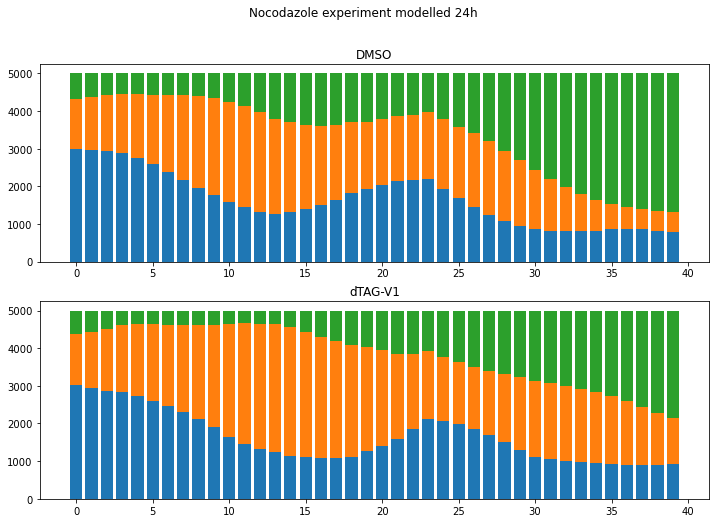

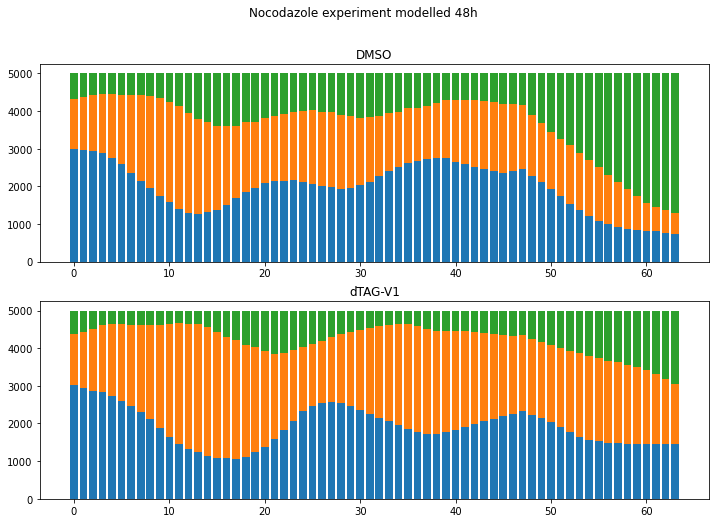

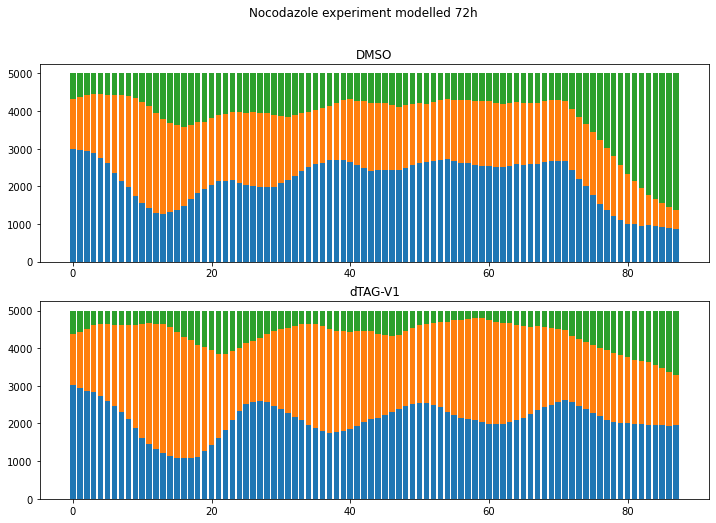

In [10]:
modelnumber=5551


numberofcells=5000
takingtimepoints24h=40
takingtimepoints48h=64
takingtimepoints72h=88

deltatimeinterval=1
weightscellcycledistributions=[60,27,13]
outputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/TempFigures/'
inputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/'

lambdaG1_DMSO_1st=0.74
kappaG1_DMSO_1st=10.5
lambdaS_DMSO_1st=18
kappaS_DMSO_1st=149
lambdaG2_DMSO_1st=13.2
kappaG2_DMSO_1st=41
lambdaM_DMSO_1st=35.5
kappaM_DMSO_1st=16
####
lambdaG1_V1_1st=0.74
kappaG1_V1_1st=10.5
lambdaS_V1_1st=15.35
kappaS_V1_1st=206.5
lambdaG2_V1_1st=13.2
kappaG2_V1_1st=41.0
lambdaM_V1_1st=35.5
kappaM_V1_1st=16

lambdaG1_DMSO_2nd=2.6
kappaG1_DMSO_2nd=12.5
lambdaS_DMSO_2nd=21.9
kappaS_DMSO_2nd=132.5
lambdaG2_DMSO_2nd=9.25
kappaG2_DMSO_2nd=29.5
lambdaM_DMSO_2nd=35.5
kappaM_DMSO_2nd=16
####
lambdaG1_V1_2nd=17.0
kappaG1_V1_2nd=120.5
lambdaS_V1_2nd=21.65
kappaS_V1_2nd=235.5
lambdaG2_V1_2nd=9.25
kappaG2_V1_2nd=21.65
lambdaM_V1_2nd=35.5
kappaM_V1_2nd=16

lambdaG1_DMSO_3rd=1.65
kappaG1_DMSO_3rd=13
lambdaS_DMSO_3rd=11.2
kappaS_DMSO_3rd=60.5
lambdaG2_DMSO_3rd=8.85
kappaG2_DMSO_3rd=17.5
lambdaM_DMSO_3rd=35.5
kappaM_DMSO_3rd=16
####
lambdaG1_V1_3rd=14.25
kappaG1_V1_3rd=88.0
lambdaS_V1_3rd=16.2
kappaS_V1_3rd=266.0
lambdaG2_V1_3rd=8.85
kappaG2_V1_3rd=17.5
lambdaM_V1_3rd=35.5
kappaM_V1_3rd=16

progression_1st=100
progression_2nd=100
stallingcells_DMSO_1st=0
stallingcells_DMSO_2nd=1
stallingcells_DMSO_3rd=1
stallingcells_V1_1st=0
stallingcells_V1_2nd=14
stallingcells_V1_3rd=14
efficiencynocodazole=70

errorcountDMSO=False
errorcountV1=False

dkappaandlambdaDMSO = {'G1 kappa':[kappaG1_DMSO_1st,kappaG1_DMSO_2nd,kappaG1_DMSO_3rd],
                        'G1 lambda':[lambdaG1_DMSO_1st,lambdaG1_DMSO_2nd,lambdaG1_DMSO_3rd],
                        'S kappa':[kappaS_DMSO_1st,kappaS_DMSO_2nd,kappaS_DMSO_3rd],
                        'S lambda':[lambdaS_DMSO_1st,lambdaS_DMSO_2nd,lambdaS_DMSO_3rd],
                        'G2 kappa':[kappaG2_DMSO_1st,kappaG2_DMSO_2nd,kappaG2_DMSO_3rd],
                        'G2 lambda':[lambdaG2_DMSO_1st,lambdaG2_DMSO_2nd,lambdaG2_DMSO_3rd],
                      'M kappa':[kappaM_DMSO_1st,kappaM_DMSO_2nd,kappaM_DMSO_3rd],
                      'M lambda':[lambdaM_DMSO_1st,lambdaM_DMSO_2nd,lambdaM_DMSO_3rd]}
dfkappaandlambdaDMSO=pd.DataFrame(data=dkappaandlambdaDMSO, index=['1st cell cycle', '2nd cell cycle','3rd cell cycle'])

dkappaandlambdaV1 = {'G1 kappa':[kappaG1_V1_1st,kappaG1_V1_2nd,kappaG1_V1_3rd],
                        'G1 lambda':[lambdaG1_V1_1st,lambdaG1_V1_2nd,lambdaG1_V1_3rd],
                        'S kappa':[kappaS_V1_1st,kappaS_V1_2nd,kappaS_V1_3rd],
                        'S lambda':[lambdaS_V1_1st,lambdaS_V1_2nd,lambdaS_V1_3rd],
                        'G2 kappa':[kappaG2_V1_1st,kappaG2_V1_2nd,kappaG2_V1_3rd],
                        'G2 lambda':[lambdaG2_V1_1st,lambdaG2_V1_2nd,lambdaG2_V1_3rd],
                    'M kappa':[kappaM_V1_1st,kappaM_V1_2nd,kappaM_V1_3rd],
                     'M lambda':[lambdaM_V1_1st,lambdaM_V1_2nd,lambdaM_V1_3rd]}
dfkappaandlambdaV1=pd.DataFrame(data=dkappaandlambdaV1, index=['1st cell cycle', '2nd cell cycle','3rd cell cycle'])

#Running model for DMSO treated cells

outputPalboDMSO=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                   lambdaG1 = lambdaG1_DMSO_1st,kappaG1 = kappaG1_DMSO_1st,lambdaS = lambdaS_DMSO_1st,kappaS = kappaS_DMSO_1st,lambdaG2 = lambdaG2_DMSO_1st,kappaG2 = kappaG2_DMSO_1st,lambdaM = lambdaM_DMSO_1st,kappaM = kappaM_DMSO_1st,
                                  outputpath=outputpath,treatment='DMSO')
outputPalboV1=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                 lambdaG1 = lambdaG1_V1_1st,kappaG1 = kappaG1_V1_1st,lambdaS = lambdaS_V1_1st,kappaS = kappaS_V1_1st,lambdaG2 = lambdaG2_V1_1st,kappaG2 = kappaG2_V1_1st,lambdaM = lambdaM_V1_1st,kappaM = kappaM_V1_1st,
                                outputpath=outputpath,treatment='V1')

dfNocoDMSO_24h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                  lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                  lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                  progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                  stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                  takingtimepoints=takingtimepoints24h,deltatime=deltatimeinterval,
                                  outputpath=outputpath,treatment='DMSO',nocodazole_after=24,efficiencynocodazole=efficiencynocodazole)

dfNocoDMSO_48h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                  lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                  lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                  progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                  stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                  takingtimepoints=takingtimepoints48h,deltatime=deltatimeinterval,
                                  outputpath=outputpath,treatment='DMSO',nocodazole_after=48,efficiencynocodazole=efficiencynocodazole)


dfNocoDMSO_72h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                  lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                  lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                  progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                  stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                  takingtimepoints=takingtimepoints72h,deltatime=deltatimeinterval,
                                  outputpath=outputpath,treatment='DMSO',nocodazole_after=72,efficiencynocodazole=efficiencynocodazole)

#Running model for dTAG-V1 treated cells
outputPalboV1=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                 lambdaG1 = lambdaG1_V1_1st,kappaG1 = kappaG1_V1_1st,lambdaS = lambdaS_V1_1st,kappaS = kappaS_V1_1st,lambdaG2 = lambdaG2_V1_1st,kappaG2 = kappaG2_V1_1st,lambdaM = lambdaM_V1_1st,kappaM = kappaM_V1_1st,
                                outputpath=outputpath,treatment='V1')


dfNocoV1_24h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                takingtimepoints=takingtimepoints24h,deltatime=deltatimeinterval,
                                outputpath=outputpath,treatment='V1',nocodazole_after=24,efficiencynocodazole=efficiencynocodazole)


dfNocoV1_48h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                takingtimepoints=takingtimepoints48h,deltatime=deltatimeinterval,
                                outputpath=outputpath,treatment='V1',nocodazole_after=48,efficiencynocodazole=efficiencynocodazole)

dfNocoV1_72h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                takingtimepoints=takingtimepoints72h,deltatime=deltatimeinterval,
                                outputpath=outputpath,treatment='V1',nocodazole_after=72,efficiencynocodazole=efficiencynocodazole)

realdata = pd.read_csv(str(inputpath+'ExperimentalData.txt'),sep='\t')
dfNocoV1_72htemp=dfNocoV1_72h.drop(columns=['time'])
concatdf = pd.concat([dfNocoDMSO_72h, dfNocoV1_72htemp], axis=1)
concatdf=concatdf.set_index('time')
concatdf=concatdf/numberofcells*100
concatdf.columns = ['G1 DMSO', 'S DMSO', 'G2M DMSO','G2 DMSO','M DMSO', 'G1 dTAG-V1','S dTAG-V1','G2M dTAG-V1','G2 dTAG-V1','M dTAG-V1']
concatdf['Time'] = concatdf.index


fig, (ax1, ax2) = plt.subplots(2,1,sharex=False,sharey=True)
fig.suptitle('Nocodazole experiment modelled 24h')
fig.set_figwidth(12)
fig.set_figheight(8)
ax1.bar(list(dfNocoDMSO_24h['time']), list(dfNocoDMSO_24h['G1']))
ax1.bar(list(dfNocoDMSO_24h['time']), list(dfNocoDMSO_24h['S']),bottom=list(dfNocoDMSO_24h['G1']))
ax1.bar(list(dfNocoDMSO_24h['time']), list(dfNocoDMSO_24h['G2M']),bottom=dfNocoDMSO_24h['S']+dfNocoDMSO_24h['G1'])
ax2.bar(list(dfNocoV1_24h['time']), list(dfNocoV1_24h['G1']))
ax2.bar(list(dfNocoV1_24h['time']), list(dfNocoV1_24h['S']),bottom=list(dfNocoV1_24h['G1']))
ax2.bar(list(dfNocoV1_24h['time']), list(dfNocoV1_24h['G2M']),bottom=dfNocoV1_24h['S']+dfNocoV1_24h['G1'])
ax1.set_title('DMSO')
ax2.set_title('dTAG-V1')
#ax1.set_xticks(dfNocoDMSO_24h['time'])
#ax2.set_xticks(dfNocoDMSO_24h['time'])

fig, (ax1, ax2) = plt.subplots(2,1,sharex=False,sharey=True)
fig.suptitle('Nocodazole experiment modelled 48h')
fig.set_figwidth(12)
fig.set_figheight(8)
ax1.bar(list(dfNocoDMSO_48h['time']), list(dfNocoDMSO_48h['G1']))
ax1.bar(list(dfNocoDMSO_48h['time']), list(dfNocoDMSO_48h['S']),bottom=list(dfNocoDMSO_48h['G1']))
ax1.bar(list(dfNocoDMSO_48h['time']), list(dfNocoDMSO_48h['G2M']),bottom=dfNocoDMSO_48h['S']+dfNocoDMSO_48h['G1'])
ax2.bar(list(dfNocoV1_48h['time']), list(dfNocoV1_48h['G1']))
ax2.bar(list(dfNocoV1_48h['time']), list(dfNocoV1_48h['S']),bottom=list(dfNocoV1_48h['G1']))
ax2.bar(list(dfNocoV1_48h['time']), list(dfNocoV1_48h['G2M']),bottom=dfNocoV1_48h['S']+dfNocoV1_48h['G1'])
ax1.set_title('DMSO')
ax2.set_title('dTAG-V1')
#ax1.set_xticks(dfNocoDMSO_48h['time'])
#ax2.set_xticks(dfNocoDMSO_48h['time'])


fig, (ax1, ax2) = plt.subplots(2,1,sharex=False,sharey=True)
fig.suptitle('Nocodazole experiment modelled 72h')
fig.set_figwidth(12)
fig.set_figheight(8)
ax1.bar(list(dfNocoDMSO_72h['time']), list(dfNocoDMSO_72h['G1']))
ax1.bar(list(dfNocoDMSO_72h['time']), list(dfNocoDMSO_72h['S']),bottom=list(dfNocoDMSO_72h['G1']))
ax1.bar(list(dfNocoDMSO_72h['time']), list(dfNocoDMSO_72h['G2M']),bottom=dfNocoDMSO_72h['S']+dfNocoDMSO_72h['G1'])
ax2.bar(list(dfNocoV1_72h['time']), list(dfNocoV1_72h['G1']))
ax2.bar(list(dfNocoV1_72h['time']), list(dfNocoV1_72h['S']),bottom=list(dfNocoV1_72h['G1']))
ax2.bar(list(dfNocoV1_72h['time']), list(dfNocoV1_72h['G2M']),bottom=dfNocoV1_72h['S']+dfNocoV1_72h['G1'])
ax1.set_title('DMSO')
ax2.set_title('dTAG-V1')
#ax1.set_xticks(dfNocoDMSO_72h['time'])
#ax2.set_xticks(dfNocoDMSO_72h['time'])

plt.show()







In [13]:
dfNocoDMSO_24h_final=dfNocoDMSO_24h.iloc[-1:]
dfNocoDMSO_48h_final=dfNocoDMSO_48h.iloc[-1:]
dfNocoDMSO_72h_final=dfNocoDMSO_72h.iloc[-1:]
dfNocoV1_24h_final=dfNocoV1_24h.iloc[-1:]
dfNocoV1_48h_final=dfNocoV1_48h.iloc[-1:]
dfNocoV1_72h_final=dfNocoV1_72h.iloc[-1:]
dfconcatalltimepoints=pd.concat([dfNocoDMSO_24h_final,dfNocoDMSO_48h_final,dfNocoDMSO_72h_final,dfNocoV1_24h_final,dfNocoV1_48h_final,dfNocoV1_72h_final])

dfconcatalltimepoints=dfconcatalltimepoints[['G1','S','G2M','G2','M']]/numberofcells*100
dfconcatalltimepoints['Sample']=['24h DMSO','48h DMSO','72h DMSO','24h V1','48h V1','72h V1']
dfconcatalltimepoints['Time']=['24h','48h','72h','24h','48h','72h']
dfconcatalltimepoints['Treatment']=['DMSO','DMSO','DMSO','dTAG-V1','dTAG-V1','dTAG-V1']

dfconcatalltimepoints

,G1,S,G2M,G2,M,Sample,Time,Treatment
39,15.82,10.28,73.90,5.30,68.60,24h DMSO,24h,DMSO
63,14.66,11.10,74.24,5.74,68.50,48h DMSO,48h,DMSO
87,17.18,10.14,72.68,5.88,66.80,72h DMSO,72h,DMSO
39,18.28,24.84,56.88,8.92,47.96,24h V1,24h,dTAG-V1
63,29.02,32.20,38.78,6.22,32.56,48h V1,48h,dTAG-V1
87,38.98,26.86,34.16,4.74,29.42,72h V1,72h,dTAG-V1


In [14]:

outputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/'
dfconcatalltimepoints.to_csv(str(outputpath+'NocoG2TrapTablemodel558.txt'), header=True, index=None, sep='\t')


In [6]:
stallingoptions=list(range(0,41,1))*7
percentageefficiency=[0.75]*41+[0.5]*41+[0.8]*41+[0.85]*41+[0.9]*41+[0.95]*41+[1]*41
print(len(stallingoptions),len(percentageefficiency))
percentageefficiency[0]

287 287


0.75

In [7]:
modelnumber=5551
Rsquares24hDMSO=[]
Rsquares24hV1=[]
Rsquares48hDMSO=[]
Rsquares48hV1=[]
Rsquares72hDMSO=[]
Rsquares72hV1=[]
RsquarespooledDMSO=[]
RsquarespooledV1=[]
Rsqaurespooledall=[]
tablepercentagestalling=[]
tablepercentageefficiency=[]

stallingoptions=list(range(0,41,1))
percentageefficiency=[100]*41

for i in range(0,len(stallingoptions)):
    numberofcells=10000
    takingtimepoints24h=40
    takingtimepoints48h=64
    takingtimepoints72h=88

    deltatimeinterval=1
    weightscellcycledistributions=[60,27,13]
    outputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/TempFigures/'
    inputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/'

    lambdaG1_DMSO_1st=0.74
    kappaG1_DMSO_1st=10.5
    lambdaS_DMSO_1st=18
    kappaS_DMSO_1st=149
    lambdaG2_DMSO_1st=13.2
    kappaG2_DMSO_1st=41
    lambdaM_DMSO_1st=35.5
    kappaM_DMSO_1st=16
    ####
    lambdaG1_V1_1st=0.74
    kappaG1_V1_1st=10.5
    lambdaS_V1_1st=15.35
    kappaS_V1_1st=206.5
    lambdaG2_V1_1st=13.2
    kappaG2_V1_1st=41.0
    lambdaM_V1_1st=35.5
    kappaM_V1_1st=16

    lambdaG1_DMSO_2nd=2.6
    kappaG1_DMSO_2nd=12.5
    lambdaS_DMSO_2nd=21.9
    kappaS_DMSO_2nd=132.5
    lambdaG2_DMSO_2nd=9.25
    kappaG2_DMSO_2nd=29.5
    lambdaM_DMSO_2nd=35.5
    kappaM_DMSO_2nd=16
    ####
    lambdaG1_V1_2nd=17.0
    kappaG1_V1_2nd=120.5
    lambdaS_V1_2nd=21.65
    kappaS_V1_2nd=235.5
    lambdaG2_V1_2nd=9.25
    kappaG2_V1_2nd=21.65
    lambdaM_V1_2nd=35.5
    kappaM_V1_2nd=16

    lambdaG1_DMSO_3rd=1.65
    kappaG1_DMSO_3rd=13
    lambdaS_DMSO_3rd=11.2
    kappaS_DMSO_3rd=60.5
    lambdaG2_DMSO_3rd=8.85
    kappaG2_DMSO_3rd=17.5
    lambdaM_DMSO_3rd=35.5
    kappaM_DMSO_3rd=16
    ####
    lambdaG1_V1_3rd=14.25
    kappaG1_V1_3rd=88.0
    lambdaS_V1_3rd=16.2
    kappaS_V1_3rd=266.0
    lambdaG2_V1_3rd=8.85
    kappaG2_V1_3rd=17.5
    lambdaM_V1_3rd=35.5
    kappaM_V1_3rd=16

    progression_1st=100
    progression_2nd=100
    stallingcells_DMSO_1st=0
    stallingcells_DMSO_2nd=stallingoptions[i]
    stallingcells_DMSO_3rd=stallingoptions[i]
    stallingcells_V1_1st=0
    stallingcells_V1_2nd=stallingoptions[i]
    stallingcells_V1_3rd=stallingoptions[i]
    efficiencynocodazole=percentageefficiency[i]

    errorcountDMSO=False
    errorcountV1=False

    dkappaandlambdaDMSO = {'G1 kappa':[kappaG1_DMSO_1st,kappaG1_DMSO_2nd,kappaG1_DMSO_3rd],
                            'G1 lambda':[lambdaG1_DMSO_1st,lambdaG1_DMSO_2nd,lambdaG1_DMSO_3rd],
                            'S kappa':[kappaS_DMSO_1st,kappaS_DMSO_2nd,kappaS_DMSO_3rd],
                            'S lambda':[lambdaS_DMSO_1st,lambdaS_DMSO_2nd,lambdaS_DMSO_3rd],
                            'G2 kappa':[kappaG2_DMSO_1st,kappaG2_DMSO_2nd,kappaG2_DMSO_3rd],
                            'G2 lambda':[lambdaG2_DMSO_1st,lambdaG2_DMSO_2nd,lambdaG2_DMSO_3rd],
                          'M kappa':[kappaM_DMSO_1st,kappaM_DMSO_2nd,kappaM_DMSO_3rd],
                          'M lambda':[lambdaM_DMSO_1st,lambdaM_DMSO_2nd,lambdaM_DMSO_3rd]}
    dfkappaandlambdaDMSO=pd.DataFrame(data=dkappaandlambdaDMSO, index=['1st cell cycle', '2nd cell cycle','3rd cell cycle'])

    dkappaandlambdaV1 = {'G1 kappa':[kappaG1_V1_1st,kappaG1_V1_2nd,kappaG1_V1_3rd],
                            'G1 lambda':[lambdaG1_V1_1st,lambdaG1_V1_2nd,lambdaG1_V1_3rd],
                            'S kappa':[kappaS_V1_1st,kappaS_V1_2nd,kappaS_V1_3rd],
                            'S lambda':[lambdaS_V1_1st,lambdaS_V1_2nd,lambdaS_V1_3rd],
                            'G2 kappa':[kappaG2_V1_1st,kappaG2_V1_2nd,kappaG2_V1_3rd],
                            'G2 lambda':[lambdaG2_V1_1st,lambdaG2_V1_2nd,lambdaG2_V1_3rd],
                        'M kappa':[kappaM_V1_1st,kappaM_V1_2nd,kappaM_V1_3rd],
                         'M lambda':[lambdaM_V1_1st,lambdaM_V1_2nd,lambdaM_V1_3rd]}
    dfkappaandlambdaV1=pd.DataFrame(data=dkappaandlambdaV1, index=['1st cell cycle', '2nd cell cycle','3rd cell cycle'])

    #Running model for DMSO treated cells

    outputPalboDMSO=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                       lambdaG1 = lambdaG1_DMSO_1st,kappaG1 = kappaG1_DMSO_1st,lambdaS = lambdaS_DMSO_1st,kappaS = kappaS_DMSO_1st,lambdaG2 = lambdaG2_DMSO_1st,kappaG2 = kappaG2_DMSO_1st,lambdaM = lambdaM_DMSO_1st,kappaM = kappaM_DMSO_1st,
                                      outputpath=outputpath,treatment='DMSO')
    outputPalboV1=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                     lambdaG1 = lambdaG1_V1_1st,kappaG1 = kappaG1_V1_1st,lambdaS = lambdaS_V1_1st,kappaS = kappaS_V1_1st,lambdaG2 = lambdaG2_V1_1st,kappaG2 = kappaG2_V1_1st,lambdaM = lambdaM_V1_1st,kappaM = kappaM_V1_1st,
                                    outputpath=outputpath,treatment='V1')

    dfNocoDMSO_24h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                      lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                      lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                      progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                      stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                      takingtimepoints=takingtimepoints24h,deltatime=deltatimeinterval,
                                      outputpath=outputpath,treatment='DMSO',nocodazole_after=24,efficiencynocodazole=efficiencynocodazole)

    dfNocoDMSO_48h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                      lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                      lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                      progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                      stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                      takingtimepoints=takingtimepoints48h,deltatime=deltatimeinterval,
                                      outputpath=outputpath,treatment='DMSO',nocodazole_after=48,efficiencynocodazole=efficiencynocodazole)


    dfNocoDMSO_72h,errorcountDMSO=NocodazoleTrapG2(outputPalboDMSO[0],outputPalboDMSO[1],outputPalboDMSO[2],outputPalboDMSO[3],outputPalboDMSO[4],outputPalboDMSO[5],outputPalboDMSO[6],
                                      lambdaG1_2nd = lambdaG1_DMSO_2nd,kappaG1_2nd = kappaG1_DMSO_2nd,lambdaS_2nd = lambdaS_DMSO_2nd,kappaS_2nd = kappaS_DMSO_2nd,lambdaG2_2nd = lambdaG2_DMSO_2nd,kappaG2_2nd = kappaG2_DMSO_2nd,lambdaM_2nd = lambdaM_DMSO_2nd,kappaM_2nd = kappaM_DMSO_2nd,
                                      lambdaG1_3rd = lambdaG1_DMSO_3rd,kappaG1_3rd = kappaG1_DMSO_3rd,lambdaS_3rd = lambdaS_DMSO_3rd,kappaS_3rd = kappaS_DMSO_3rd,lambdaG2_3rd = lambdaG2_DMSO_3rd,kappaG2_3rd = kappaG2_DMSO_3rd,lambdaM_3rd = lambdaM_DMSO_3rd,kappaM_3rd = kappaM_DMSO_3rd,
                                      progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                      stallingcells_1st_G1=stallingcells_DMSO_1st,stallingcells_2nd_G1=stallingcells_DMSO_2nd,stallingcells_3rd_G1=stallingcells_DMSO_3rd,
                                      takingtimepoints=takingtimepoints72h,deltatime=deltatimeinterval,
                                      outputpath=outputpath,treatment='DMSO',nocodazole_after=72,efficiencynocodazole=efficiencynocodazole)

    #Running model for dTAG-V1 treated cells
    outputPalboV1=gettingstartpoints(numberofcells = numberofcells,weightscellcycledistributions=weightscellcycledistributions,
                                     lambdaG1 = lambdaG1_V1_1st,kappaG1 = kappaG1_V1_1st,lambdaS = lambdaS_V1_1st,kappaS = kappaS_V1_1st,lambdaG2 = lambdaG2_V1_1st,kappaG2 = kappaG2_V1_1st,lambdaM = lambdaM_V1_1st,kappaM = kappaM_V1_1st,
                                    outputpath=outputpath,treatment='V1')


    dfNocoV1_24h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                    lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                    lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                    progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                    stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                    takingtimepoints=takingtimepoints24h,deltatime=deltatimeinterval,
                                    outputpath=outputpath,treatment='V1',nocodazole_after=24,efficiencynocodazole=efficiencynocodazole)


    dfNocoV1_48h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                    lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                    lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                    progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                    stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                    takingtimepoints=takingtimepoints48h,deltatime=deltatimeinterval,
                                    outputpath=outputpath,treatment='V1',nocodazole_after=48,efficiencynocodazole=efficiencynocodazole)

    dfNocoV1_72h,errorcountV1=NocodazoleTrapG2(outputPalboV1[0],outputPalboV1[1],outputPalboV1[2],outputPalboV1[3],outputPalboV1[4],outputPalboV1[5],outputPalboV1[6],
                                    lambdaG1_2nd = lambdaG1_V1_2nd,kappaG1_2nd = kappaG1_V1_2nd,lambdaS_2nd = lambdaS_V1_2nd,kappaS_2nd = kappaS_V1_2nd,lambdaG2_2nd = lambdaG2_V1_2nd,kappaG2_2nd = kappaG2_V1_2nd,lambdaM_2nd = lambdaM_V1_2nd,kappaM_2nd = kappaM_V1_2nd,
                                    lambdaG1_3rd = lambdaG1_V1_3rd,kappaG1_3rd = kappaG1_V1_3rd,lambdaS_3rd = lambdaS_V1_3rd,kappaS_3rd = kappaS_V1_3rd,lambdaG2_3rd = lambdaG2_V1_3rd,kappaG2_3rd = kappaG2_V1_3rd,lambdaM_3rd = lambdaM_V1_3rd,kappaM_3rd = kappaM_V1_3rd,
                                    progressionpercentage=progression_1st,progressionpercentage_2nd=progression_2nd,
                                    stallingcells_1st_G1=stallingcells_V1_1st,stallingcells_2nd_G1=stallingcells_V1_2nd,stallingcells_3rd_G1=stallingcells_V1_3rd,
                                    takingtimepoints=takingtimepoints72h,deltatime=deltatimeinterval,
                                    outputpath=outputpath,treatment='V1',nocodazole_after=72,efficiencynocodazole=efficiencynocodazole)

    realdata = pd.read_csv(str(inputpath+'ExperimentalData.txt'),sep='\t')
    dfNocoV1_72htemp=dfNocoV1_72h.drop(columns=['time'])
    concatdf = pd.concat([dfNocoDMSO_72h, dfNocoV1_72htemp], axis=1)
    concatdf=concatdf.set_index('time')
    concatdf=concatdf/numberofcells*100
    concatdf.columns = ['G1 DMSO', 'S DMSO', 'G2M DMSO','G2 DMSO','M DMSO', 'G1 dTAG-V1','S dTAG-V1','G2M dTAG-V1','G2 dTAG-V1','M dTAG-V1']
    concatdf['Time'] = concatdf.index

    dfNocoDMSO_24h_final=dfNocoDMSO_24h.iloc[-1:]
    dfNocoDMSO_48h_final=dfNocoDMSO_48h.iloc[-1:]
    dfNocoDMSO_72h_final=dfNocoDMSO_72h.iloc[-1:]
    dfNocoV1_24h_final=dfNocoV1_24h.iloc[-1:]
    dfNocoV1_48h_final=dfNocoV1_48h.iloc[-1:]
    dfNocoV1_72h_final=dfNocoV1_72h.iloc[-1:]
    dfconcatalltimepoints=pd.concat([dfNocoDMSO_24h_final,dfNocoDMSO_48h_final,dfNocoDMSO_72h_final,dfNocoV1_24h_final,dfNocoV1_48h_final,dfNocoV1_72h_final])

    dfconcatalltimepoints=dfconcatalltimepoints[['G1','S','G2M','G2','M']]/numberofcells*100
    dfconcatalltimepoints['Sample']=['24h DMSO','48h DMSO','72h DMSO','24h V1','48h V1','72h V1']
    dfconcatalltimepoints['Time']=['24h','48h','72h','24h','48h','72h']
    dfconcatalltimepoints['Treatment']=['DMSO','DMSO','DMSO','V1','V1','V1']

    textoutputpercentagestallingnumber=str(stallingcells_DMSO_1st)+','+str(stallingcells_DMSO_2nd)+','+str(stallingcells_DMSO_3rd)+'_'+str(stallingcells_V1_1st)+','+str(stallingcells_V1_2nd)+','+str(stallingcells_V1_3rd)
    textoutputpercentageefficiency=str(percentageefficiency[i])
    outputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Modelling cell cycle/'
    dfconcatalltimepoints.to_csv(str(outputpath+'NocoG2TrapTablemodel_'+textoutputpercentagestallingnumber+'_'+textoutputpercentageefficiency+'.txt'), header=True, index=None, sep='\t')


    inputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Report/Data Nocodazole/'
    realdata = pd.read_csv(str(inputpath+'CombinedQuantificationNocodazole2.txt'),sep='\t')

    exp24hDMSO=[realdata.iloc[0,4],realdata.iloc[0,5],realdata.iloc[0,6]]
    exp24hV1=[realdata.iloc[1,4],realdata.iloc[1,5],realdata.iloc[1,6]]
    exp48hDMSO=[realdata.iloc[2,4],realdata.iloc[2,5],realdata.iloc[2,6]]
    exp48hV1=[realdata.iloc[3,4],realdata.iloc[3,5],realdata.iloc[3,6]]
    exp72hDMSO=[realdata.iloc[4,4],realdata.iloc[4,5],realdata.iloc[4,6]]
    exp72hV1=[realdata.iloc[5,4],realdata.iloc[5,5],realdata.iloc[5,6]]

    model24hDMSO=[dfconcatalltimepoints.iloc[0,0],dfconcatalltimepoints.iloc[0,1],dfconcatalltimepoints.iloc[0,2]]
    model24hV1=[dfconcatalltimepoints.iloc[3,0],dfconcatalltimepoints.iloc[3,1],dfconcatalltimepoints.iloc[3,2]]
    model48hDMSO=[dfconcatalltimepoints.iloc[1,0],dfconcatalltimepoints.iloc[1,1],dfconcatalltimepoints.iloc[1,2]]
    model48hV1=[dfconcatalltimepoints.iloc[4,0],dfconcatalltimepoints.iloc[4,1],dfconcatalltimepoints.iloc[4,2]]
    model72hDMSO=[dfconcatalltimepoints.iloc[2,0],dfconcatalltimepoints.iloc[2,1],dfconcatalltimepoints.iloc[2,2]]
    model72hV1=[dfconcatalltimepoints.iloc[5,0],dfconcatalltimepoints.iloc[5,1],dfconcatalltimepoints.iloc[5,2]]

    SSres24hDMSO=0
    SStot24hDMSO=0
    SSres24hV1=0
    SStot24hV1=0
    SSres48hDMSO=0
    SStot48hDMSO=0
    SSres48hV1=0
    SStot48hV1=0
    SSres72hDMSO=0
    SStot72hDMSO=0
    SSres72hV1=0
    SStot72hV1=0
    pooledSSresDMSO=0
    pooledSStotDMSO=0
    pooledSSresV1=0
    pooledSStotV1=0
    pooledSSresall=0
    pooledSStotall=0

    loop=0
    for loop in range(0,3):
        #print('i',loop)
        SSres24hDMSO+=(exp24hDMSO[loop]-model24hDMSO[loop])**2
        SStot24hDMSO+=(exp24hDMSO[loop]-statistics.mean(exp24hDMSO))**2
        SSres24hV1+=(exp24hV1[loop]-model24hV1[loop])**2
        SStot24hV1+=(exp24hV1[loop]-statistics.mean(exp24hV1))**2
        SSres48hDMSO+=(exp48hDMSO[loop]-model48hDMSO[loop])**2
        SStot48hDMSO+=(exp48hDMSO[loop]-statistics.mean(exp48hDMSO))**2
        SSres48hV1+=(exp48hV1[loop]-model48hV1[loop])**2
        SStot48hV1+=(exp48hV1[loop]-statistics.mean(exp48hV1))**2
        SSres72hDMSO+=(exp72hDMSO[loop]-model72hDMSO[loop])**2
        SStot72hDMSO+=(exp72hDMSO[loop]-statistics.mean(exp72hDMSO))**2
        SSres72hV1+=(exp72hV1[loop]-model72hV1[loop])**2
        SStot72hV1+=(exp72hV1[loop]-statistics.mean(exp72hV1))**2

    print(stallingoptions[i])
    print('R square 24h DMSO: ',1-(SSres24hDMSO/SStot24hDMSO))
    print('R square 24h V1: ',1-(SSres24hV1/SStot24hV1))
    print('R square 48h DMSO: ',1-(SSres48hDMSO/SStot48hDMSO))
    print('R square 48h V1: ',1-(SSres48hV1/SStot48hV1))
    print('R square 72h DMSO: ',1-(SSres72hDMSO/SStot72hDMSO))
    print('R square 72h V1: ',1-(SSres72hV1/SStot72hV1))
    print()
    pooledSSresDMSO=SSres24hDMSO+SSres48hDMSO+SSres72hDMSO
    pooledSStotDMSO=SStot24hDMSO+SStot48hDMSO+SStot72hDMSO
    pooledSSresV1=SSres24hV1+SSres48hV1+SSres72hV1
    pooledSStotV1=SStot24hV1+SStot48hV1+SStot72hV1
    pooledSSresall=pooledSSresDMSO+pooledSSresV1
    pooledSStotall=pooledSStotDMSO+pooledSStotV1
    
    Rsquares24hDMSO+=[1-(SSres24hDMSO/SStot24hDMSO)]
    Rsquares24hV1+=[1-(SSres24hV1/SStot24hV1)]
    Rsquares48hDMSO+=[1-(SSres48hDMSO/SStot48hDMSO)]
    Rsquares48hV1+=[1-(SSres48hV1/SStot48hV1)]
    Rsquares72hDMSO+=[1-(SSres72hDMSO/SStot72hDMSO)]
    Rsquares72hV1+=[1-(SSres72hV1/SStot72hV1)]
    RsquarespooledDMSO+=[1-(pooledSSresDMSO/pooledSStotDMSO)]
    RsquarespooledV1+=[1-(pooledSSresV1/pooledSStotV1)]
    Rsqaurespooledall+=[1-(pooledSSresall/pooledSStotall)]
    
    tablepercentagestalling+=[stallingoptions[i]]
    tablepercentageefficiency+=[percentageefficiency[i]]

outputfiletextRsquare=str(percentageefficiency[i])
df = pd.DataFrame(list(zip(stallingoptions,percentageefficiency,
                           Rsquares24hDMSO, Rsquares24hV1,Rsquares48hDMSO,Rsquares48hV1,
                           Rsquares72hDMSO,Rsquares72hV1,RsquarespooledDMSO,RsquarespooledV1,Rsqaurespooledall)),
               columns =['StallingPercentage','EfficiencyPercentage',
                         'Rsquares24hDMSO', 'Rsquares24hV1',
                         'Rsquares48hDMSO','Rsquares48hV1',
                         'Rsquares72hDMSO','Rsquares72hV1',
                        'RsquarespooledDMSO','RsquarespooledV1',
                        'Rsquarespooledall'])
outputpath='C:/Users/Gebruiker/OneDrive - Universiteit Utrecht/CSDB/Major Internship/Report/Data Model/'
df.to_csv(str(outputpath+'NocoG2TrapTablemodel_allRsquares_'+outputfiletextRsquare+'.txt'), header=True, index=None, sep='\t')


0
R square 24h DMSO:  0.6240868087845062
R square 24h V1:  -2.799840806782825
R square 48h DMSO:  0.1291291131780753
R square 48h V1:  -3.4011891191311365
R square 72h DMSO:  0.25805828111025375
R square 72h V1:  -10.764058219718747

1
R square 24h DMSO:  0.6567701023080004
R square 24h V1:  -2.6491920447441646
R square 48h DMSO:  0.28013695563597485
R square 48h V1:  -2.852909685593624
R square 72h DMSO:  0.442597715768126
R square 72h V1:  -9.001666334116406

2
R square 24h DMSO:  0.6932210948869241
R square 24h V1:  -2.525228287244112
R square 48h DMSO:  0.4010441564842562
R square 48h V1:  -2.383176275656647
R square 72h DMSO:  0.5717734817885349
R square 72h V1:  -7.406777909245932

3
R square 24h DMSO:  0.7192930442153728
R square 24h V1:  -2.422880759531157
R square 48h DMSO:  0.49748891195401823
R square 48h V1:  -1.8135202777382289
R square 72h DMSO:  0.676600395493695
R square 72h V1:  -5.866353396532088

4
R square 24h DMSO:  0.7520811394369302
R square 24h V1:  -2.424994820

35
R square 24h DMSO:  0.6405640314508412
R square 24h V1:  -0.871783893189372
R square 48h DMSO:  -1.4775831981200898
R square 48h V1:  -2.5516839926013137
R square 72h DMSO:  -3.1927537606433214
R square 72h V1:  -9.683674883026285

36
R square 24h DMSO:  0.5607273191619259
R square 24h V1:  -0.8642147687767503
R square 48h DMSO:  -1.5272444777438494
R square 48h V1:  -3.213158272650622
R square 72h DMSO:  -3.3012155191294017
R square 72h V1:  -10.7617252346887

37
R square 24h DMSO:  0.5534422876934544
R square 24h V1:  -0.9071577620417934
R square 48h DMSO:  -1.6864613385993246
R square 48h V1:  -3.3475197638441285
R square 72h DMSO:  -3.3357305285395826
R square 72h V1:  -11.177506698241645

38
R square 24h DMSO:  0.535467643253698
R square 24h V1:  -0.8718615972261949
R square 48h DMSO:  -1.8601360663573252
R square 48h V1:  -3.811510984709799
R square 72h DMSO:  -3.5914210145537533
R square 72h V1:  -12.511196372585822

39
R square 24h DMSO:  0.5282343521102897
R square 24h V1: 

In [ ]:
df = pd.DataFrame(list(zip(stallingoptions,Rsquares24hDMSO, Rsquares24hV1,Rsquares48hDMSO,Rsquares48hV1,
                           Rsquares72hDMSO,Rsquares72hV1,RsquarespooledDMSO,RsquarespooledV1,Rsqaurespooledall)),
               columns =['StallingPercentage','Rsquares24hDMSO', 'Rsquares24hV1',
                         'Rsquares48hDMSO','Rsquares48hV1',
                         'Rsquares72hDMSO','Rsquares72hV1',
                        'RsquarespooledDMSO','RsquarespooledV1',
                        'Rsquarespooledall'])

df.to_csv(str(outputpath+'NocoG2TrapTablemodel_allRsquares_3.txt'), header=True, index=None, sep='\t')


In [ ]:
Rsquaredata = pd.read_csv(str(outputpath+'NocoG2TrapTablemodel_allRsquares_2.txt'),sep='\t')
Rsquaredata

In [ ]:

Rsquaredata.plot.line(x='StallingPercentage',figsize=(10, 5))